## First easy example of convolution

In [151]:
using Images, TestImages, PyPlot, BenchmarkTools

INFO: Recompiling stale cache file /Users/davidbuchaca1/.julia/lib/v0.6/BenchmarkTools.ji for module BenchmarkTools.


In [11]:
img = testimage("lena_gray");
img1 = Gray.(img);

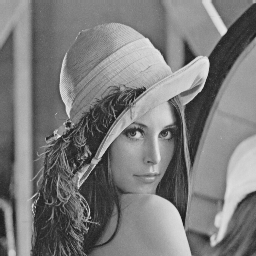

In [12]:
img1

In [14]:
size(img1)

(256, 256)

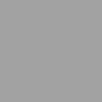

In [54]:
img1[1:3,1:3]

#### Apply Kernel

Let us consider the kernel 

```
1 0 -1
1 0 -1
1 0 -1
```

We would like to apply it at every possible position in the image. 

This mask is overlapped into the original image and the elementwise product of the values is computed.
Then it is added to get the value of the output.



In [53]:
K = [[1,1,1]  [0,0,0]  [-1,-1,-1]]

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [104]:
X = Float32.(img1);

In [105]:
# This is the value that has to go to the Out[1,1]
sum(X[1:3,1:3].*K)

-1.1920929f-7

In [106]:
# This is the value that has to go to the Out[1,2]
sum(X[2:4,2:4].*K)

0.007843137f0

In [142]:
function convolution_2d_1(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(X[w:w+f-1, h:h+f-1] .* K)
        end
    end
    
    return output
end

convolution_2d_1 (generic function with 1 method)

In [146]:
@time Xconv = convolution_2d_1(X,K);

  0.010599 seconds (256.05 k allocations: 20.023 MiB, 38.05% gc time)


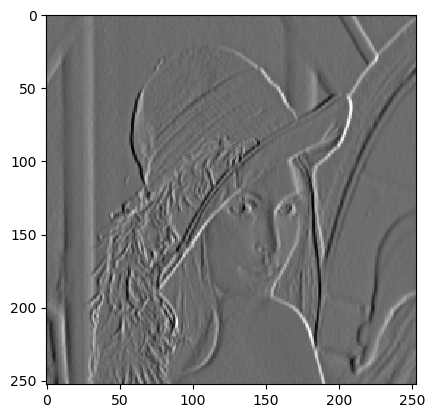

PyObject <matplotlib.image.AxesImage object at 0x1348f1910>

In [148]:
PyPlot.imshow(Xconv, cmap="gray")

In [153]:
@benchmark convolution_2d_1(X,K)

BenchmarkTools.Trial: 
  memory estimate:  20.02 MiB
  allocs estimate:  256038
  --------------
  minimum time:     6.043 ms (0.00% GC)
  median time:      8.070 ms (21.06% GC)
  mean time:        8.013 ms (19.63% GC)
  maximum time:     25.419 ms (16.34% GC)
  --------------
  samples:          624
  evals/sample:     1

### Improving speed Using views

In [154]:
function convolution_2d_2(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(view(X,w:w+f-1, h:h+f-1) .* K)
        end
    end
    
    return output
end

convolution_2d_2 (generic function with 1 method)

In [155]:
@benchmark convolution_2d_2(X,K)

BenchmarkTools.Trial: 
  memory estimate:  8.30 MiB
  allocs estimate:  64011
  --------------
  minimum time:     3.331 ms (0.00% GC)
  median time:      3.584 ms (0.00% GC)
  mean time:        3.922 ms (10.46% GC)
  maximum time:     5.814 ms (25.06% GC)
  --------------
  samples:          1273
  evals/sample:     1

In [157]:
Xconv2 = convolution_2d_2(X,K);

In [161]:
Xconv == Xconv2

true

### Change `X[w:w+f-1, h:h+f-1] .* K` by a double for loop


In [331]:
w = 10
h = 1
f = 3

3

In [332]:
K

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [363]:
X[w:w+f-1, h:h+f-1]

3×3 Array{Float32,2}:
 0.615686  0.623529  0.619608
 0.611765  0.607843  0.607843
 0.623529  0.607843  0.6     

In [378]:
X[w,h], X[w+1,h], X[w+2,h]

(0.6156863f0, 0.6117647f0, 0.62352943f0)

In [386]:
X[w,h+1], X[w+1,h+1], X[w+2,h+1]  

(0.62352943f0, 0.60784316f0, 0.60784316f0)

In [394]:
X[w,h+2], X[w+1,h+2], X[w+2,h+2] 

(0.61960787f0, 0.60784316f0, 0.6f0)

In [400]:
aux = 0.
l = 1
for row in w:w+f-1
    #println("w",w)
    for col in h:h+f-1
        println("row: ", row, "\tcol: ", col, "\tX[col,row]: ", X[row,col])
    end
end

row: 10	col: 1	X[col,row]: 0.6156863
row: 10	col: 2	X[col,row]: 0.62352943
row: 10	col: 3	X[col,row]: 0.61960787
row: 11	col: 1	X[col,row]: 0.6117647
row: 11	col: 2	X[col,row]: 0.60784316
row: 11	col: 3	X[col,row]: 0.60784316
row: 12	col: 1	X[col,row]: 0.62352943
row: 12	col: 2	X[col,row]: 0.60784316
row: 12	col: 3	X[col,row]: 0.6


#### 

In [381]:
X[w,h+1], X[w,h+2], X[w,h+3]  

(0.62352943f0, 0.61960787f0, 0.6039216f0)

In [374]:
Array(w:w+f-1)

3-element Array{Int64,1}:
 10
 11
 12

In [377]:
Array(h:h+f-1)

3-element Array{Int64,1}:
 1
 2
 3

In [361]:
sum(X[w:w+f-1, h:h+f-1] .* K)

0.02352941f0

We would like to compute the previous computation with a loop

In [337]:
aux = 0.
l = 1
for col in w:w+f-1
    #println("w",w)
    for row in h:h+f-1
        #println("row: ",row,"\tcol: ",col,"\tl: ",l)
        aux += X[col,row] * K[l]
        l +=1
    end
end

In [339]:
aux

0.027450978755950928

In [273]:
function convolution_2d_3(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in w:w+f-1
                #println("w",w)
                for row in h:h+f-1
                    #println("row: ",row,"\tcol: ",col,"\tl: ",l)
                    aux += X[col,row] * K[l]
                    l +=1
                end
            end
            output[w,h] = aux
            #println("DONE")
            #return
        end
    end
    
    return output

end

convolution_2d_3 (generic function with 1 method)

In [277]:
Xconv3 = convolution_2d_3(X,K)

253×253 Array{Float64,2}:
  0.0          0.0          0.0         …   0.0          0.0       
  0.0117647    0.0196078    0.0470588       0.184314     0.533333  
  0.054902     0.0509804    0.0431373       0.564706     1.05098   
  0.0588235    0.0588235    0.0352941       0.694118     0.717647  
  0.0          0.00392157   0.0117647       0.490196     0.25098   
 -0.0156863   -0.0196078    0.00392157  …   0.2          0.0117647 
  0.0117647    0.0117647    0.027451        0.0941177    0.027451  
 -0.00784314   0.00392157  -0.00392157      0.0196079    0.027451  
  0.0117647    0.0156863    0.0            -0.0627451   -0.0470588 
  0.027451     0.027451     0.0117647      -0.00392157  -0.00392157
  0.00392157  -0.00784314  -0.00392157  …   0.0470588    0.00784312
  0.0313725    0.00784314  -0.00392157      1.49012e-8  -0.0470588 
 -0.0470588   -0.027451    -0.0156863      -0.0627451   -0.0235294 
  ⋮                                     ⋱                          
  0.121569    -0.02352

In [275]:
Xconv3 == Xconv2

false

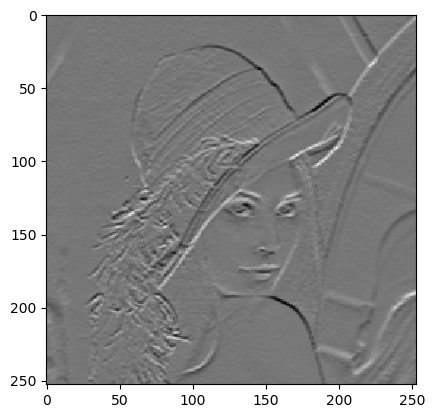

PyObject <matplotlib.image.AxesImage object at 0x146567150>

In [276]:
PyPlot.imshow(Xconv3, cmap="gray")

In [283]:
@benchmark convolution_2d_3(X,K)

BenchmarkTools.Trial: 
  memory estimate:  500.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     826.098 μs (0.00% GC)
  median time:      975.648 μs (0.00% GC)
  mean time:        988.081 μs (3.79% GC)
  maximum time:     2.971 ms (63.49% GC)
  --------------
  samples:          5045
  evals/sample:     1